In [1]:
import matplotlib.pyplot as plt
import numpy as np
from gate import AddGate, MultiplyGate, DotGate, BiasGate, SigmoidGate, ReluGate, SoftmaxGate

In [2]:
np.random.seed(1)

In [3]:
def load_dataset():
    np.random.seed(1)
    m = 800 # number of examples
    C = 4
    N = int(m/C) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 7 # maximum ray of the flower

    for j in range(C):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(3*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t+j*3.14/2), r*np.cos(t+j*3.14/2)]
        Y[ix] = j
        pass
        
    X = X.T
    Y = Y.T

    return X, Y

In [4]:
X, Y = load_dataset()

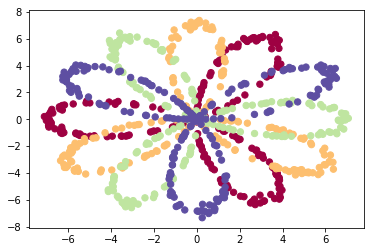

In [5]:
plt.scatter(X[0, :], X[1, :], c=Y[0, :], s=40, cmap=plt.cm.Spectral)
plt.show()

In [6]:
print(X.shape)
print(Y.shape)

(2, 800)
(1, 800)


In [7]:
n_classes = np.max(np.squeeze(Y)) + 1
Y_softmax = np.eye(n_classes)[np.squeeze(Y)]
Y_softmax = Y_softmax.T
print(Y_softmax)  

[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]]


In [8]:
W1 = np.random.randn(25, 2) * np.sqrt(2 / 2)
b1 = np.zeros((25, 1))
W2 = np.random.randn(12, 25) * np.sqrt(2 / 25)
b2 = np.zeros((12, 1))
W3 = np.random.randn(4, 12) * np.sqrt(2 / 12)
b3 = np.zeros((4, 1))

In [9]:
d1 = DotGate()
z1 = BiasGate()
a1 = ReluGate()
d2 = DotGate()
z2 = BiasGate()
a2 = ReluGate()
d3 = DotGate()
z3 = BiasGate()
a3 = SoftmaxGate()

In [10]:
n, m = X.shape
costs = []
lr = 0.08
for i in range(20000):
    # forward
    D1 = d1.forward(W1, X)
    Z1 = z1.forward(D1, b1)
    A1 = a1.forward(Z1)
    D2 = d2.forward(W2, A1)
    Z2 = z2.forward(D2, b2)
    A2 = a2.forward(Z2)
    D3 = d3.forward(W3, A2)
    Z3 = z3.forward(D3, b3)
    A3 = a3.forward(Z3)
    # cost
    logprobs = -np.multiply(Y_softmax, np.log(A3))
    cost = 1.0/m * np.nansum(logprobs)
    cost = np.squeeze(cost)
    costs.append(cost)
    # backward
    dA3 = 1.0/m * -np.squeeze((Y_softmax/A3))
    dZ3 = a3.backward(dA3)
    dD3, db3 = z3.backward(dZ3)
    dW3, dA2 = d3.backward(dD3)
    dZ2 = a2.backward(dA2)
    dD2, db2 = z2.backward(dZ2)
    dW2, dA1 = d2.backward(dD2)
    dZ1 = a1.backward(dA1)
    dD1, db1 = z1.backward(dZ1)
    dW1, _ = d1.backward(dD1)
    # update
    W3 = W3 - lr*dW3
    b3 = b3 - lr*db3
    W2 = W2 - lr*dW2
    b2 = b2 - lr*db2
    W1 = W1 - lr*dW1
    b1 = b1 - lr*db1
    if i%1000 == 0 :
        print('Cost after epoch ' + str(i) + ': ' + str(cost))
        pass
    pass

Cost after epoch 0: 10.139936572448725
Cost after epoch 1000: 0.7093080044154398
Cost after epoch 2000: 0.6576696590831589
Cost after epoch 3000: 0.640363322853755
Cost after epoch 4000: 0.6060439190949422
Cost after epoch 5000: 0.5734361689061996
Cost after epoch 6000: 0.5448891227559556
Cost after epoch 7000: 0.5208035479847924
Cost after epoch 8000: 0.4909241256556053
Cost after epoch 9000: 0.44390733914362335
Cost after epoch 10000: 0.5081509015226827
Cost after epoch 11000: 0.42346707182001
Cost after epoch 12000: 0.3773704372501675
Cost after epoch 13000: 0.355472953503268
Cost after epoch 14000: 0.3235966071601996
Cost after epoch 15000: 0.36079564363546246
Cost after epoch 16000: 0.3060308867805776
Cost after epoch 17000: 0.30961125115776755
Cost after epoch 18000: 0.29387543360902674
Cost after epoch 19000: 0.2907493100751087


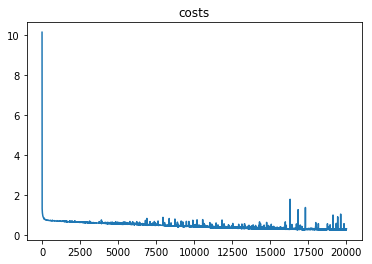

In [11]:
plt.plot(costs)
plt.title('costs')
plt.show()

In [12]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

In [13]:
def predict(X):
    n, m = X.shape
    # forward
    D1 = d1.forward(W1, X)
    Z1 = z1.forward(D1, b1)
    A1 = a1.forward(Z1)
    D2 = d2.forward(W2, A1)
    Z2 = z2.forward(D2, b2)
    A2 = a2.forward(Z2)
    D3 = d3.forward(W3, A2)
    Z3 = z3.forward(D3, b3)
    A3 = a3.forward(Z3)
    predictions = np.squeeze(np.argmax(A3, axis=0))
    return predictions

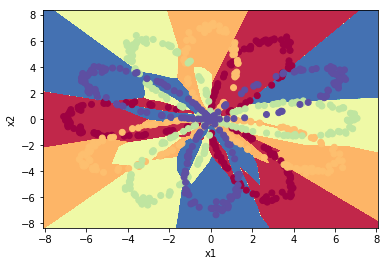

In [14]:
plot_decision_boundary(lambda x: predict(x.T), X, Y[0, :])